In [1]:
import numpy as np
import pyshtools
import spherical_inr as sph
import matplotlib.pyplot as plt


import torch_harmonics as th
import torch
from sklearn.preprocessing import StandardScaler
import imageio.v3 as iio


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
L = 50
phi, theta, (nlon, nlat) = sph.sample_s2(L, sampling = "gl", torch_tensor = True)

N_test = 5000
phi_test, theta_test = sph.sample_s2_uniform(N_test, torch_tensor = True)

In [4]:
coefficients = pyshtools.datasets.Earth.Earth2014.tbi(lmax = 200)

In [5]:
world_map = coefficients.expand(lon = phi.numpy().flatten(),  colat = theta.numpy().flatten(), degrees=False, nthreads=0).reshape(nlat, nlon)
world_map_test = coefficients.expand(lon = phi_test.numpy().flatten(), colat = theta_test.numpy().flatten(), degrees=False, nthreads=0).reshape(N_test)

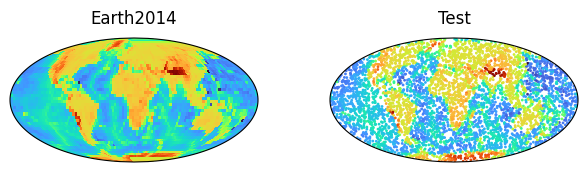

In [6]:
fig = plt.figure()
subfigs = fig.subfigures(1, 2)
sph.plot_sphere(world_map, molweide=True, cmap = "turbo", title = "Earth2014", fig = subfigs[0])
sph.plot_sphere_scatter(world_map_test, lon = phi_test, lat = theta_test, molweide=True, cmap = "turbo", title = "Test", fig = subfigs[1], s = 1)
plt.show()

In [7]:
scaler = StandardScaler()
world_map_scaled = scaler.fit_transform(world_map.reshape(-1, 1)).reshape(nlat, nlon)
world_map_test_scaled = scaler.transform(world_map_test.reshape(-1, 1)).reshape(N_test)

X = torch.stack([theta.flatten(), phi.flatten()], dim=-1).float()
y = torch.tensor(world_map_scaled.copy()).flatten().unsqueeze(1).float()

X_test = torch.stack([theta_test.flatten(), phi_test.flatten()], dim=-1).float()
y_test = torch.tensor(world_map_test_scaled.copy()).flatten().unsqueeze(1).float()

# Move tensors to the selected device
X = X.to(device)
y = y.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

In [8]:
activation_degrees = [(3, 2)]
dict_train_losses = {}
dict_test_losses = {}
dict_predictions = {}

In [ ]:
for (deg_first, deg_subseq) in activation_degrees:

    shinr = sph.SphericalNet(

        L0 = 15, 
        Q = 3,
        hidden_features = 100, 
        spectral_norm=True,
        bias = True,
        activation = sph.Chebyshev(order = deg_subseq, alpha = 1.0), 
        first_activation=sph.Chebyshev(order = deg_first, alpha = 1.0), 
        device=device
        
    )

    dict_train_losses[(deg_first, deg_subseq)], dict_test_losses[(deg_first, deg_subseq)] = sph.train(
        model = shinr, 
        x = X, 
        y = y, 
        epochs = 200,#000, 
        batch_size=2048,
        optimizer = torch.optim.Adam(shinr.parameters(), lr=1e-3),
        loss_fn= torch.nn.MSELoss(), 
        validation_data=(X_test, y_test),
        device=device
        )
    
    pred = shinr(X).cpu().detach().numpy().reshape(nlat, nlon)
    dict_predictions[(deg_first, deg_subseq)] = scaler.inverse_transform(pred)


shinr = sph.SphericalNet(

    L0 = 15, 
    Q = 3,
    hidden_features = 100, 
    activation = torch.sin, 
    first_activation=lambda x : torch.sin(5*x),
    device=device    
)

dict_train_losses["SphericalSIREN"], dict_test_losses["SphericalSIREN"] = sph.train(
    model = shinr, 
    x = X, 
    y = y, 
    epochs = 200,#000, 
    batch_size=2048,
    optimizer = torch.optim.Adam(shinr.parameters(), lr=1e-3),
    loss_fn= torch.nn.MSELoss(),
    validation_data=(X_test, y_test),
    device=device
    )

pred = shinr(X).detach().numpy()
dict_predictions["SphericalSIREN"] = scaler.inverse_transform(pred.reshape(-1, 1)).reshape(nlat, nlon)

In [10]:
siren = sph.SirenNet(

    in_features=2, 
    hidden_features=100,
    n_hidden_layers=5,
    out_features=1,
    first_omega_0=5.0,
    hidden_omega=5.0,
    
).to(device)


dict_train_losses["SIREN"], dict_test_losses["SIREN"] = sph.train(
    model = siren, 
    x = X, 
    y = y, 
    epochs = 200,#000, 
    batch_size=2048,
    optimizer = torch.optim.AdamW(siren.parameters(), lr=1e-3),
    loss_fn= torch.nn.MSELoss(), 
    validation_data=(X_test, y_test),
    device = device
    )


pred = siren(X).detach().numpy()
dict_predictions["SIREN"] = scaler.inverse_transform(pred.reshape(-1, 1)).reshape(nlat, nlon)

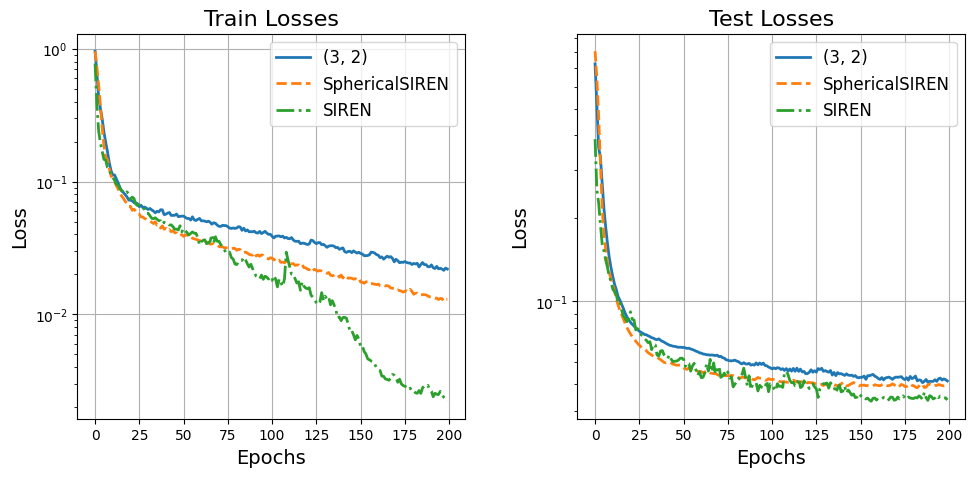

In [11]:
fig = plt.figure(figsize=(10, 5))
subfigs = fig.subfigures(1, 2)
sph.plot_losses(dict_train_losses, fig = subfigs[0], title = "Train Losses")
sph.plot_losses(dict_test_losses, fig = subfigs[1], title = "Test Losses")
plt.show()

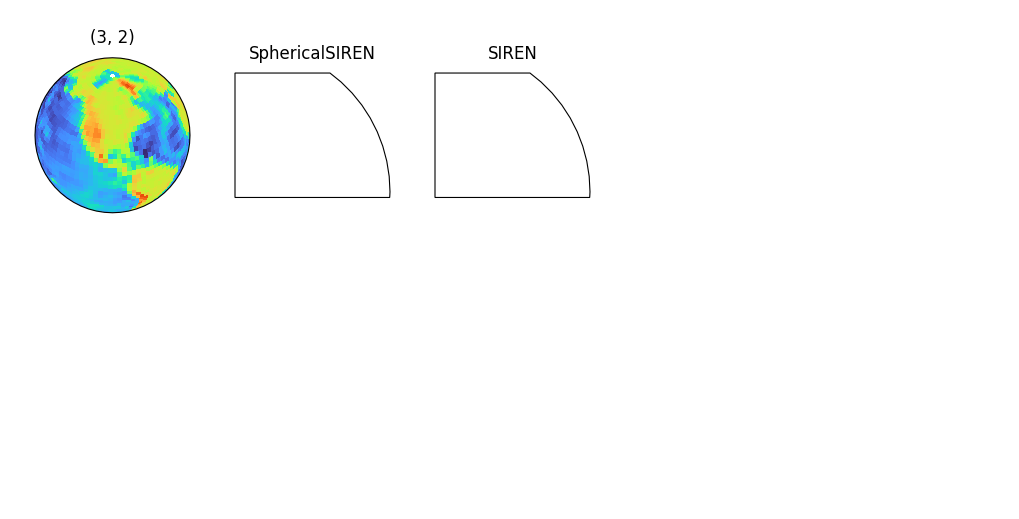

In [12]:
fig = plt.figure(figsize=(10, 5))
subfigs = fig.subfigures(2, 5)
subfigs = subfigs.flatten()

for i, (label, pred) in enumerate(dict_predictions.items()):
    sph.plot_sphere(pred, cmap = "turbo", title = label, central_latitude=40, central_longitude=-90, fig=subfigs[i])

plt.show()